## Policy evaluation

In [1]:
import gym
import pandas as pd
import ray
from ray.tune.registry import register_env
from ray.rllib.agents import ppo
from ray import serve, tune

from config import Config
from data_prep import DataPrep
from env import CMAPSSEnv
from VAE_dense import *
from tf_serve_models import TFEncoderDecoderModel

In [2]:
const = Config()
neurons = const.VAE_neurons

# Data prep
# Load the 3rd batch of data which are for policy evaluation
data = DataPrep(file = const.file_path,
                num_settings = const.num_settings,
                num_sensors = const.num_sensors,
                num_units = const.num_units[2],
                prev_step_units = const.prev_step_units[2],
                step = const.step[2],
                normalization_type="01")

df = data.ReadData()
#print(df)

# List of engine lifetimes
engine_lives = df.groupby(df['Unit']).size()
engine_lives = engine_lives.tolist()
num_engines = len(engine_lives)

Initialize Ray, load the environment and the optimal checkpoint, run test data

In [4]:
ray.init()

2022-07-17 17:24:52,591	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.8.12', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-07-17_17-24-50_497750_25619/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-07-17_17-24-50_497750_25619/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-07-17_17-24-50_497750_25619', 'metrics_export_port': 64554, 'gcs_address': '127.0.0.1:65337', 'address': '127.0.0.1:65337', 'node_id': '3f10de23e0dc747ee0d065dbce1c4f8e668814da62a0f2703a9716b5'})

In [5]:
# Load options
serve.start()
TFEncoderDecoderModel.deploy(['./saved_models/encoder','./saved_models/decoder'])

# Environment types
env_types = ["batch", "intertemporal"]

##########################################
env_config = {
    "df": df,
    "timestep": 0,
    "obs_size": const.num_settings+const.num_sensors+1,
    "engines": num_engines,
    "engine_lives": engine_lives, 
    "models": [None, None],
    "env_type": env_types[1],
}

env_name = "CMAPSS_env"
env_wrapper_config = gym.wrappers.FrameStack(CMAPSSEnv(**env_config), const.num_frames)
register_env(env_name, lambda config: env_wrapper_config)

(ServeController pid=25676) 2022-07-17 17:24:58,840	INFO checkpoint_path.py:15 -- Using RayInternalKVStore for controller checkpoint and recovery.
(ServeController pid=25676) 2022-07-17 17:24:58,944	INFO http_state.py:106 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:XxsvKe:SERVE_PROXY_ACTOR-node:127.0.0.1-0' on node 'node:127.0.0.1-0' listening on '127.0.0.1:8000'
2022-07-17 17:24:59,630	INFO api.py:794 -- Started Serve instance in namespace '0c9e1d27-a637-43eb-b1c1-b9a7c47c494c'.
2022-07-17 17:24:59,635	INFO api.py:615 -- Updating deployment 'TFEncoderDecoderModel'. component=serve deployment=TFEncoderDecoderModel
(ServeController pid=25676) 2022-07-17 17:24:59,669	INFO deployment_state.py:1210 -- Adding 1 replicas to deployment 'TFEncoderDecoderModel'. component=serve deployment=TFEncoderDecoderModel
(HTTPProxyActor pid=25678) INFO:     Started server process [25678]
2022-07-17 17:25:03,652	INFO api.py:630 -- Deployment 'TFEncoderDecoderModel' is ready at `http://127.0.0.

In [6]:
analysis = tune.ExperimentAnalysis(experiment_checkpoint_path="/Users/erotokritosskordilis/ray_results/CMAPSS_env/experiment_state-2022-07-17_14-06-05.json")

2022-07-17 17:25:03,711	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


In [7]:
# Locate checkpoints

checkpoint_path = "/Users/erotokritosskordilis/ray_results/CMAPSS_env/PPO_CMAPSS_env_2040f_00000_0_2022-07-17_14-06-05/checkpoint_000100/checkpoint-100"


In [8]:
# Restore agent from last checkpoint

agent = ppo.PPOTrainer(
    config={
            "env": env_name,
            "num_workers": 1,
            "num_gpus": 0,
            "log_level": "INFO",
            "explore": False,
            "model":{
                "fcnet_hiddens": const.policy_neurons,
                "fcnet_activation": "relu",
                "free_log_std": True,
            }
        })

agent.restore(checkpoint_path)

2022-07-17 17:25:07,783	INFO trainer.py:2295 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-07-17 17:25:07,787	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(RolloutWorker pid=25684) 2022-07-17 17:25:12,006	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=25684) 2022-07-17 17:25:12,006	WARNI

In [9]:
env = gym.wrappers.FrameStack(CMAPSSEnv(**env_config), const.num_frames)

In [106]:
import bisect

obs, done = env.reset(), False
cntr = 0

s = bisect.bisect_left(np.cumsum(engine_lives), env.timestep)
steps_to_go = abs(env.timestep - np.cumsum(engine_lives[:s+1])[-1]) - 1
current_step = abs(engine_lives[s] - steps_to_go)
print(f'Current step: {current_step},System: {s}, System life: {engine_lives[s]}, Steps until failure: {steps_to_go}')

Current step: 101,System: 4, System life: 253, Steps until failure: 152


In [107]:
eval_data = np.empty([steps_to_go, const.num_frames, const.num_settings + const.num_sensors + 1])
eval_data.shape

(152, 50, 25)

In [108]:
while not done:
    action = agent.compute_single_action(obs)
    obs, _, done, _ = env.step(action)
    eval_data[cntr] = obs
    cntr += 1

In [109]:
eval_data_avg = np.empty([steps_to_go, const.num_settings + const.num_sensors + 1])

for i in range(steps_to_go):
    eval_data_avg[i] = np.mean(eval_data[i,:,:], axis=0)

eval_data_avg[:,0]

array([5.98214467e-01, 5.95662432e-01, 5.93136360e-01, 5.90586407e-01,
       5.88032174e-01, 5.85502206e-01, 5.82951554e-01, 5.80410177e-01,
       5.77845394e-01, 5.75288403e-01, 5.72718656e-01, 5.70115158e-01,
       5.67491397e-01, 5.64825156e-01, 5.62108351e-01, 5.59356228e-01,
       5.56563393e-01, 5.53711300e-01, 5.50828618e-01, 5.47897778e-01,
       5.44934533e-01, 5.41930685e-01, 5.38870555e-01, 5.35788106e-01,
       5.32665329e-01, 5.29462906e-01, 5.26200196e-01, 5.22905323e-01,
       5.19543757e-01, 5.16138599e-01, 5.12654860e-01, 5.09108002e-01,
       5.05471813e-01, 5.01769358e-01, 4.97986440e-01, 4.94141774e-01,
       4.90218671e-01, 4.86235104e-01, 4.82185604e-01, 4.78051759e-01,
       4.73845286e-01, 4.69570191e-01, 4.65176091e-01, 4.60707648e-01,
       4.56152280e-01, 4.51477319e-01, 4.46671855e-01, 4.41742452e-01,
       4.36742163e-01, 4.31615809e-01, 4.28910239e-01, 4.26124743e-01,
       4.23253041e-01, 4.20337047e-01, 4.17362226e-01, 4.14296870e-01,
      

In [110]:
test_engine_df = df.iloc[np.cumsum(engine_lives[:s])[-1]+current_step:np.cumsum(engine_lives[:s])[-1]\
                         +engine_lives[s],1:].reset_index(drop=True)
test_engine_df

,NormTime,OpSetting1,OpSetting2,OpSetting3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,...,Sensor12,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21
0,0.596838,0.575442,0.680214,0.842795,0.372231,0.398699,0.478070,0.428745,0.381246,0.366305,...,0.342120,0.837997,0.558985,0.368110,0.329694,0.465983,0.654904,0.842795,0.356927,0.358025
1,0.592885,0.575334,0.680381,0.842966,0.372509,0.398989,0.478277,0.428878,0.381384,0.366451,...,0.342261,0.838167,0.558970,0.368056,0.329335,0.466194,0.655133,0.842966,0.357072,0.358171
2,0.588933,0.574966,0.679963,0.843137,0.372755,0.399248,0.478521,0.429183,0.381641,0.366721,...,0.342556,0.838336,0.559152,0.367792,0.330065,0.466440,0.655350,0.843137,0.357371,0.358472
3,0.584980,0.574859,0.680128,0.843308,0.373031,0.399532,0.478724,0.429304,0.381778,0.366867,...,0.342696,0.838506,0.559132,0.367754,0.329706,0.466638,0.655577,0.843308,0.357519,0.358614
4,0.581028,0.575321,0.680474,0.843478,0.372626,0.399242,0.478552,0.429115,0.381363,0.366468,...,0.342326,0.838674,0.559175,0.367767,0.329348,0.466432,0.655547,0.843478,0.357137,0.358238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0.015810,0.578913,0.685714,0.845720,0.369263,0.397423,0.478215,0.428716,0.377301,0.362564,...,0.338482,0.840920,0.560510,0.369421,0.332079,0.465993,0.655936,0.845720,0.353326,0.354317
148,0.011858,0.578593,0.685349,0.845865,0.369478,0.397655,0.478464,0.429025,0.377526,0.362802,...,0.338738,0.841064,0.560735,0.369217,0.332707,0.466245,0.656122,0.845865,0.353583,0.354566
149,0.007905,0.578273,0.684984,0.846009,0.369693,0.397895,0.478700,0.429317,0.377751,0.363040,...,0.338994,0.841208,0.560965,0.368995,0.333333,0.466497,0.656308,0.846009,0.353835,0.354814
150,0.003953,0.578289,0.685033,0.845216,0.369569,0.397541,0.478336,0.429003,0.377672,0.362895,...,0.338760,0.840423,0.560586,0.369568,0.333021,0.466129,0.655693,0.845216,0.353630,0.354605


In [30]:
test_engine_df = df.iloc[current_step:engine_lives[s],1:].reset_index(drop=True)
test_engine_df

,NormTime,OpSetting1,OpSetting2,OpSetting3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,...,Sensor12,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21
0,0.377049,0.532754,0.631756,0.833333,0.419699,0.434800,0.499890,0.452551,0.423960,0.408253,...,0.383250,0.828271,0.537665,0.356610,0.342105,0.488522,0.665758,0.833333,0.397609,0.398221
1,0.371585,0.535367,0.634938,0.834783,0.416573,0.432629,0.498507,0.450861,0.421548,0.405956,...,0.381106,0.829712,0.537979,0.356737,0.339130,0.487142,0.665631,0.834783,0.395494,0.396172
2,0.366120,0.532804,0.632024,0.836207,0.418137,0.434383,0.500441,0.453031,0.423235,0.407764,...,0.383126,0.831128,0.539537,0.354701,0.344828,0.489087,0.667256,0.836207,0.397500,0.398129
3,0.360656,0.535373,0.635148,0.837607,0.415078,0.432279,0.499005,0.451423,0.420870,0.405510,...,0.381009,0.832521,0.539899,0.354821,0.341880,0.487725,0.667118,0.837607,0.395461,0.396089
4,0.355191,0.537898,0.638220,0.838983,0.412071,0.430168,0.497582,0.449727,0.418546,0.403294,...,0.378936,0.833889,0.540190,0.354936,0.338983,0.486296,0.666983,0.838983,0.393412,0.394059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.021858,0.537205,0.640279,0.837989,0.405869,0.426034,0.499250,0.453009,0.417534,0.402224,...,0.377301,0.833194,0.558733,0.360184,0.363128,0.487816,0.663978,0.837989,0.391509,0.392189
66,0.016393,0.537527,0.640813,0.833333,0.404937,0.423776,0.496902,0.451002,0.416843,0.401150,...,0.375694,0.828588,0.556681,0.363642,0.361111,0.485343,0.660289,0.833333,0.390020,0.390736
67,0.010929,0.539161,0.642784,0.834254,0.403033,0.422511,0.496048,0.450102,0.415350,0.399732,...,0.374362,0.829516,0.557376,0.363727,0.359116,0.484601,0.660239,0.834254,0.388705,0.389395
68,0.005464,0.540776,0.644734,0.835165,0.401150,0.421285,0.495374,0.449258,0.413873,0.398331,...,0.373042,0.830435,0.558218,0.363819,0.357143,0.483867,0.660189,0.835165,0.387399,0.388132


In [111]:

eval_df = pd.DataFrame(eval_data_avg, columns=df.columns[1:])

## Plotting results

Plot true RUL against estimated RUL from VAE and RL methods

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

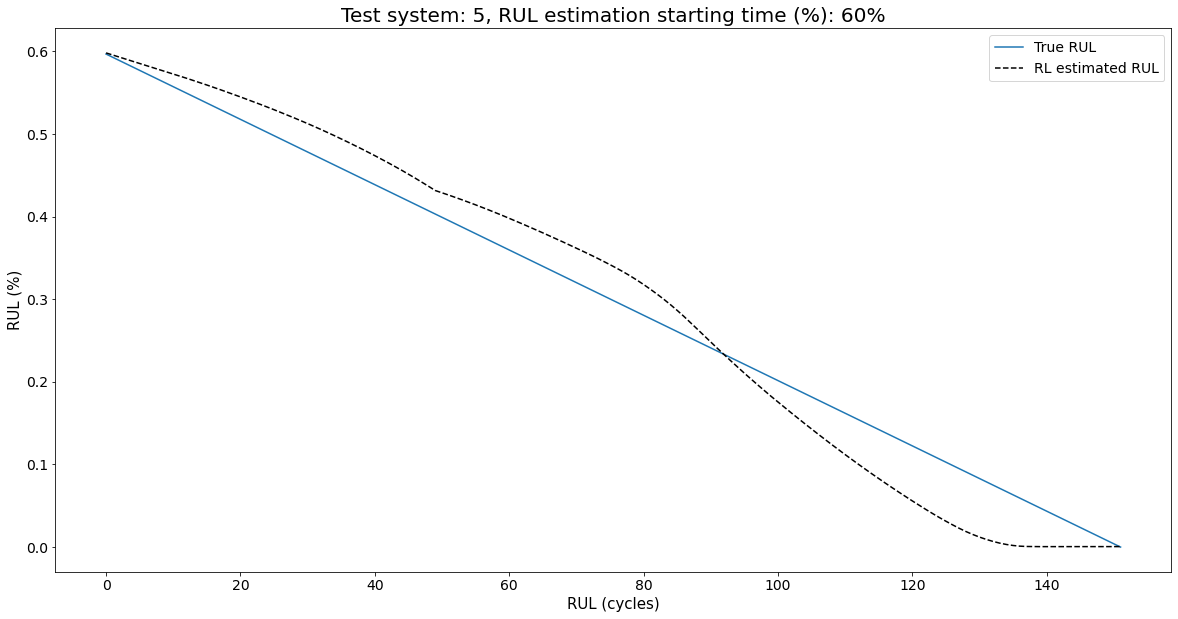

In [112]:
# '''
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(test_engine_df['NormTime'],label="True RUL")
plt.plot(eval_df['NormTime'].iloc[:steps_to_go], color='black', ls='--', label="RL estimated RUL")
#plt.plot(test_engine_decoded_df['NormTime'].iloc[:steps_to_go], color='red', ls='-.', label="VAE estimated RUL")
plt.legend(prop={'size': 14})
#plt.title('True vs. Estimated RUL', size=20)
plt.title('Test system: 5, RUL estimation starting time (%): 60%', size=20)
plt.xlabel('RUL (cycles)', size=15)
plt.xticks(fontsize=14)
plt.ylabel('RUL (%)', size=15)
plt.yticks(fontsize=14)


## Tabulated averages

In [171]:
lifetimes_true = {}
lifetimes_est = {}

In [172]:
for i in range(100):
    obs, done = env.reset(), False
    cntr = 0

    s = bisect.bisect_left(np.cumsum(engine_lives), env.timestep)
    steps_to_go = abs(env.timestep - np.cumsum(engine_lives[:s+1])[-1]) - 1
    current_step = abs(engine_lives[s] - steps_to_go)
    if steps_to_go == 0:
        continue
    #print(f'Current step: {current_step},System: {s}, System life: {engine_lives[s]}, Steps until failure: {steps_to_go}')
    
    eval_data = np.empty([steps_to_go, const.num_frames, const.num_settings + const.num_sensors + 1])
    
    while not done:
        action = agent.compute_single_action(obs)
        obs, _, done, _ = env.step(action)
        eval_data[cntr] = obs
        cntr += 1
        
    eval_data_avg = np.empty([steps_to_go, const.num_settings + const.num_sensors + 1])

    for i in range(steps_to_go):
        eval_data_avg[i] = np.mean(eval_data[i,:,:], axis=0)
    
    if s == 0:
        test_engine_df = df.iloc[current_step:engine_lives[s],1:].reset_index(drop=True)
    else:
        test_engine_df = df.iloc[np.cumsum(engine_lives[:s])[-1]+current_step:np.cumsum(engine_lives[:s])[-1]\
                             +engine_lives[s],1:].reset_index(drop=True)
    
    eval_df = pd.DataFrame(eval_data_avg, columns=df.columns[1:])
    
    lifetimes_true[i] = test_engine_df["NormTime"].iloc[::-1].reset_index(drop=True)
    lifetimes_est[i] = eval_df["NormTime"].iloc[::-1].reset_index(drop=True)

#print(lifetimes_true, lifetimes_est)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [175]:
lifetime_df = pd.DataFrame(lifetimes_true)[::-1]*100
lifetime_est_df = pd.DataFrame(lifetimes_est)[::-1]*100

In [181]:
comp = pd.concat([round(lifetime_df.mean(axis=1),2), round(lifetime_est_df.mean(axis=1),2)], axis=1).tail(20)
comp.columns = ["True RUL (%)", "Estimated RUL (%)"]

In [182]:
comp

,True RUL (%),Estimated RUL (%)
19,8.27,8.99
18,7.84,8.69
17,7.40,8.39
16,6.97,8.09
15,6.53,7.80
14,6.10,7.52
13,5.66,7.25
12,5.24,6.96
11,4.80,6.69
10,4.36,6.43


In [187]:
with pd.ExcelWriter("comparisons.xlsx") as writer:
    comp.to_excel(writer) 

In [62]:
ray.shutdown()